In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

# Orange Trees: Non-linear growth curve

In [52]:
data = {'x' : [118, 484, 664, 1004, 1231, 1372, 1582], #Instants de mesure
        'Y' : [[30, 58, 87, 115, 120, 142, 145], [33, 69, 111, 156, 172, 203, 203], #Pour chacun des 5 arbres, on a les circonférences mesurées aux 7 instants x
            [30, 51, 75, 108, 115, 139, 140], [32, 62, 112, 167, 179, 209, 214],
            [30, 49, 81, 125, 142, 174, 177]]
        }         

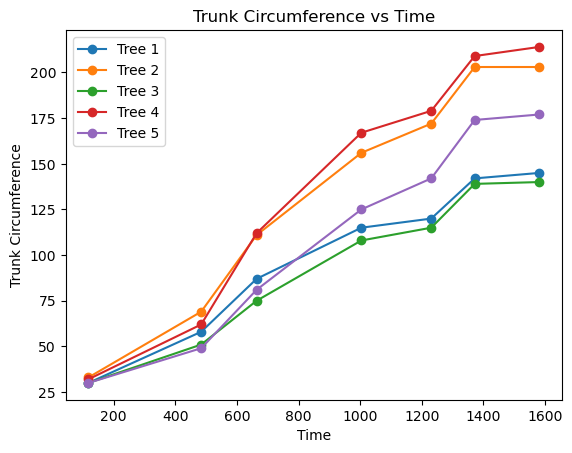

In [53]:
#Affichons l'évolution de la circonférence pour chaque arbre
for i in range(len(data['Y'])):
    plt.plot(data['x'], data['Y'][i], '-o', label='Tree '+str(i+1))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Trunk Circumference')
plt.title('Trunk Circumference vs Time')
plt.show()

In [ ]:
def MH_within_Gibbs_Orange_Trees(nchain, data, init_chain_thetas, init_chain_tau_C, init_chain_mu_k, init_chain_tau_k, priors_mu_k, priors_tau_k, priors_tau_C, prop_sd_theta):

    chain_thetas = np.zeros((nchain, 5, 3)) # 15 chaines pour les theta_i_k
    chain_mu_k = np.zeros((nchain, 3)) # 3 chaines pour les mu_k
    chain_tau_k = np.zeros((nchain, 3)) # 3 chaines pour les tau_k
    chain_tau_C = np.zeros((nchain, 1)) # 1 chaine pour tau_C

    #Initialisations des chaines
    chain_thetas[0] = init_chain_thetas #Format 5 x 3
    chain_mu_k[0] = init_chain_mu_k #Format 3 x 1
    chain_tau_k[0] = init_chain_tau_k #Format 3 x 1 
    chain_tau_C[0] = init_chain_tau_C #Format 1 x 1

    x = np.array(data['x']) #Instants de mesure
    I = len(data['Y']) #Nombre d'arbres (5)
    J = len(x) #Nombre d'instants de mesure (7)
    K = 3 
    acc_rates_theta = np.zeros((I, K)) #Taux d'acceptation pour chaque chaine theta_i_k

    
    for t in range(1, nchain) :
        chain_thetas[t] = chain_thetas[t-1]
        chain_mu_k[t] = chain_mu_k[t-1]
        chain_tau_k[t] = chain_tau_k[t-1]
        chain_tau_C[t] = chain_tau_C[t-1]
        
        def update_eta(theta): #Mise à jour de η_ij pour chaque arbre i et chaque x_j
            phi_1 = np.exp(theta[:, 0])  # ϕ_i1 = exp(θ_i1)
            phi_2 = np.exp(theta[:, 1]) - 1  # ϕ_i2 = exp(θ_i2) - 1
            phi_3 = -np.exp(theta[:, 2])  # ϕ_i3 = -exp(θ_i3)

            eta = np.zeros((I, J))
            for i in range(I):
                for j in range(J):
                    eta[i, j] = phi_1[i] / (1 + phi_2[i] * np.exp(phi_3[i] * x[j]))
            return eta
        
        #Distribution conditionnelle non identifiée des thetas (à cause de la courbe logistique dans le modèle) (on en prend le log pour qu'il n'y ait pas d'overflow)
        def log_thetas_distribution(value, i, k):
            eta = update_eta(chain_thetas[t])
            log_likelihood = -chain_tau_C[t] * np.sum((data['Y'][i]-eta[i])**2) / 2
            log_prior = -chain_tau_k[t][k] * (value-chain_mu_k[t][k])**2 / 2
            return log_prior + log_likelihood



        #Mise à jour des 3 chaines mu_k (façon Gibbs)
        for k in range(K):
            chain_mu_k[t][k] = np.random.normal(
                loc = (priors_mu_k[0]*priors_mu_k[1] + chain_tau_k[t][k]*np.sum(chain_thetas[t][:,k]))/(I*chain_tau_k[t][k] + priors_mu_k[1]), 
                scale = 1/np.sqrt((I * chain_tau_k[t][k] + priors_mu_k[1])) 
            )
        chain_mu_k[t] = [5.2, 2.22, -5.8]
            
        
        #Mise à jour des 3 chaines tau_k (façon Gibbs)
        for k in range(K):
            alpha = priors_tau_k[0] + I / 2
            beta = priors_tau_k[1] + 0.5 * np.sum((chain_thetas[t][:,k] - chain_mu_k[t][k]) ** 2) #On avait fait une erreur ici !
            chain_tau_k[t][k] = np.random.gamma(
                shape = alpha, 
                scale = 1/beta # avec gamma theta = 1 / beta  échelle
            )
        
        #Mise à jour de la chaine tau_C (façon Gibbs)
        eta = update_eta(chain_thetas[t])
        alpha = priors_tau_C[0] + I*J/2
        beta = priors_tau_C[1] + 0.5 * np.sum((data['Y'] - eta)**2)
        chain_tau_C[t] = np.random.gamma(
            shape = alpha, 
            scale = 1/beta
        )

        #Mise à jour des 15 chaines theta_i_k (façon Metropolis-Hastings, avec proba d'acception etc)
        for i in range(I):
            for k in range(K):
                if k == 0 or k == 1 : 
                    current_theta = chain_thetas[t][i][k]
                    proposal = np.random.lognormal(mean = np.log(current_theta), sigma = prop_sd_theta[k])
                    alpha = np.exp(log_thetas_distribution(proposal, i, k) - log_thetas_distribution(current_theta, i, k)) * (proposal / current_theta)
                    if np.random.uniform() < alpha :
                        chain_thetas[t][i][k] = proposal
                        acc_rates_theta[i][k] += 1
                else : #k == 2 : on distingue ce cas car c'est le seul pour lequel on ne fait pas une Random Walk, puisque les valeurs des theta_i_3 sont négatives (c'est forcé par la courbe logistique)
                    current_theta = chain_thetas[t][i][k]
                    proposal = np.random.normal(loc=current_theta, scale= prop_sd_theta[k])
                    log_alpha = log_thetas_distribution(proposal, i, k) - log_thetas_distribution(current_theta, i, k)
                    if np.log(np.random.uniform()) < log_alpha :
                        chain_thetas[t][i][k] = proposal
                        acc_rates_theta[i][k] += 1

    return chain_thetas, chain_mu_k, chain_tau_k, chain_tau_C, eta, acc_rates_theta / nchain

In [164]:
#Données d'initialisation proposées dans l'énoncé
init_chain_theta = np.array([[5, 2, -6], [5, 2, -6], [5, 2, -6], [5, 2, -6], [5, 2, -6]])
init_chain_tau_C = np.array(0.2)
init_chain_mu_k = np.array([5, 2, -6])
init_chain_tau_k = np.array([2, 2, 2])

#Paramètres des lois à priori
priors_tau_C = np.array([1e-3, 1e-3]) #notés alpha_C et beta_C dans le rapport
priors_mu_k = np.array([0, 1e-4]) #notés m_k et t_k
priors_tau_k = np.array([1e-3, 1e-3]) #notés alpha_k et beta_k
nchain = 10000
prop_sd_theta = [0.2, 0.2, 0.2]

In [242]:
chain_thetas, chain_mu_k, chain_tau_k, chain_tau_C, eta, theta_acc_rates = MH_within_Gibbs_Orange_Trees(nchain, data, init_chain_theta, init_chain_tau_C, init_chain_mu_k, init_chain_tau_k, priors_mu_k, priors_tau_k, priors_tau_C, prop_sd_theta)

## Analyse des chaines

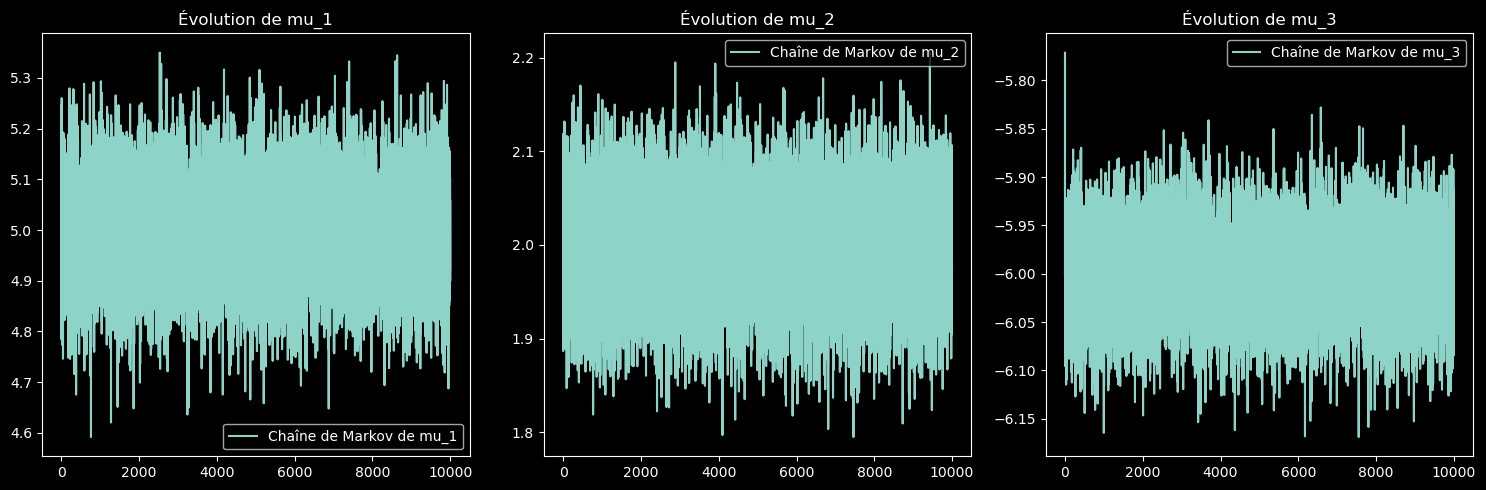

In [235]:
plt.style.use("dark_background")
n_k = chain_mu_k.shape[1]

#Chaines des mu_k générés
plt.figure(figsize=(15, 5))
for i in range(n_k):
    plt.subplot(1, n_k, i + 1)
    plt.plot(chain_mu_k[:, i], label=f'Chaîne de Markov de mu_{i+1}')
    plt.legend()
    plt.title(f"Évolution de mu_{i+1}")
plt.tight_layout()
plt.show()

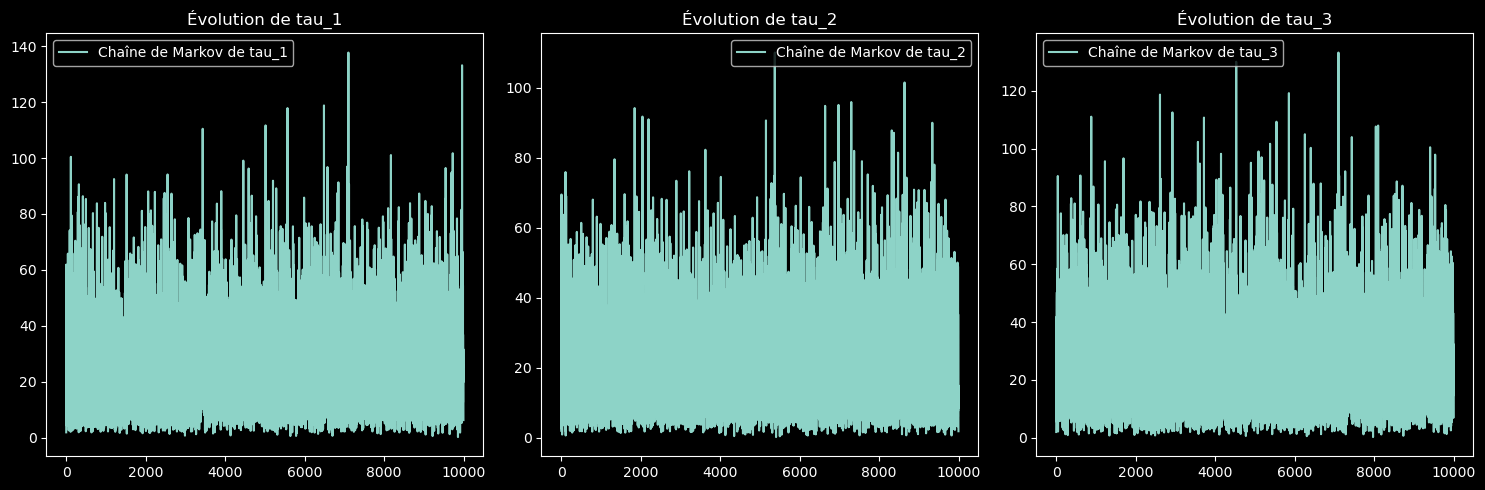

In [239]:
#Chaines des tau_k générés
plt.figure(figsize=(15, 5))
for i in range(n_k):
    plt.subplot(1, n_k, i + 1)
    plt.plot(chain_tau_k[:, i], label=f'Chaîne de Markov de tau_{i+1}')
    plt.legend()
    plt.title(f"Évolution de tau_{i+1}")
plt.tight_layout()
plt.show()

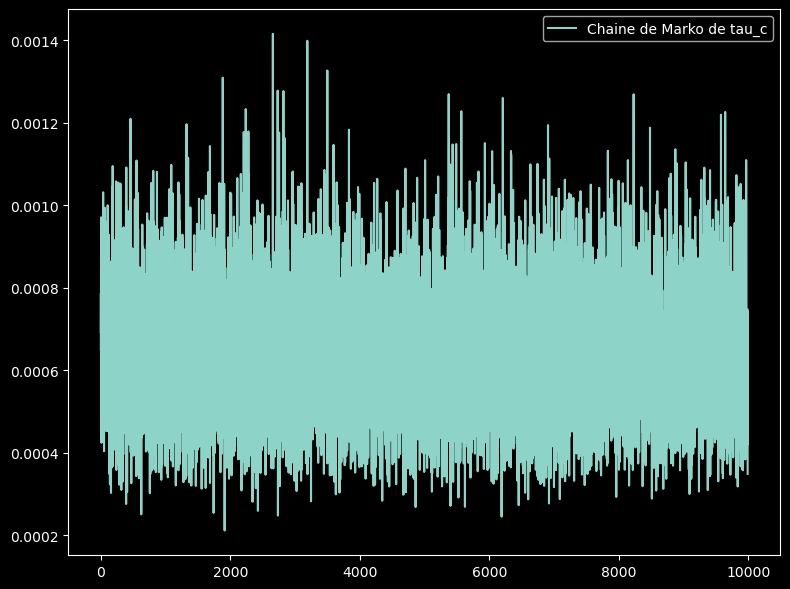

In [243]:
#Chaine de tau_c générée
plt.figure(figsize=(8,6))
plt.plot(chain_tau_C[10:], label='Chaine de Marko de tau_c')
plt.legend()
plt.tight_layout()
plt.show()

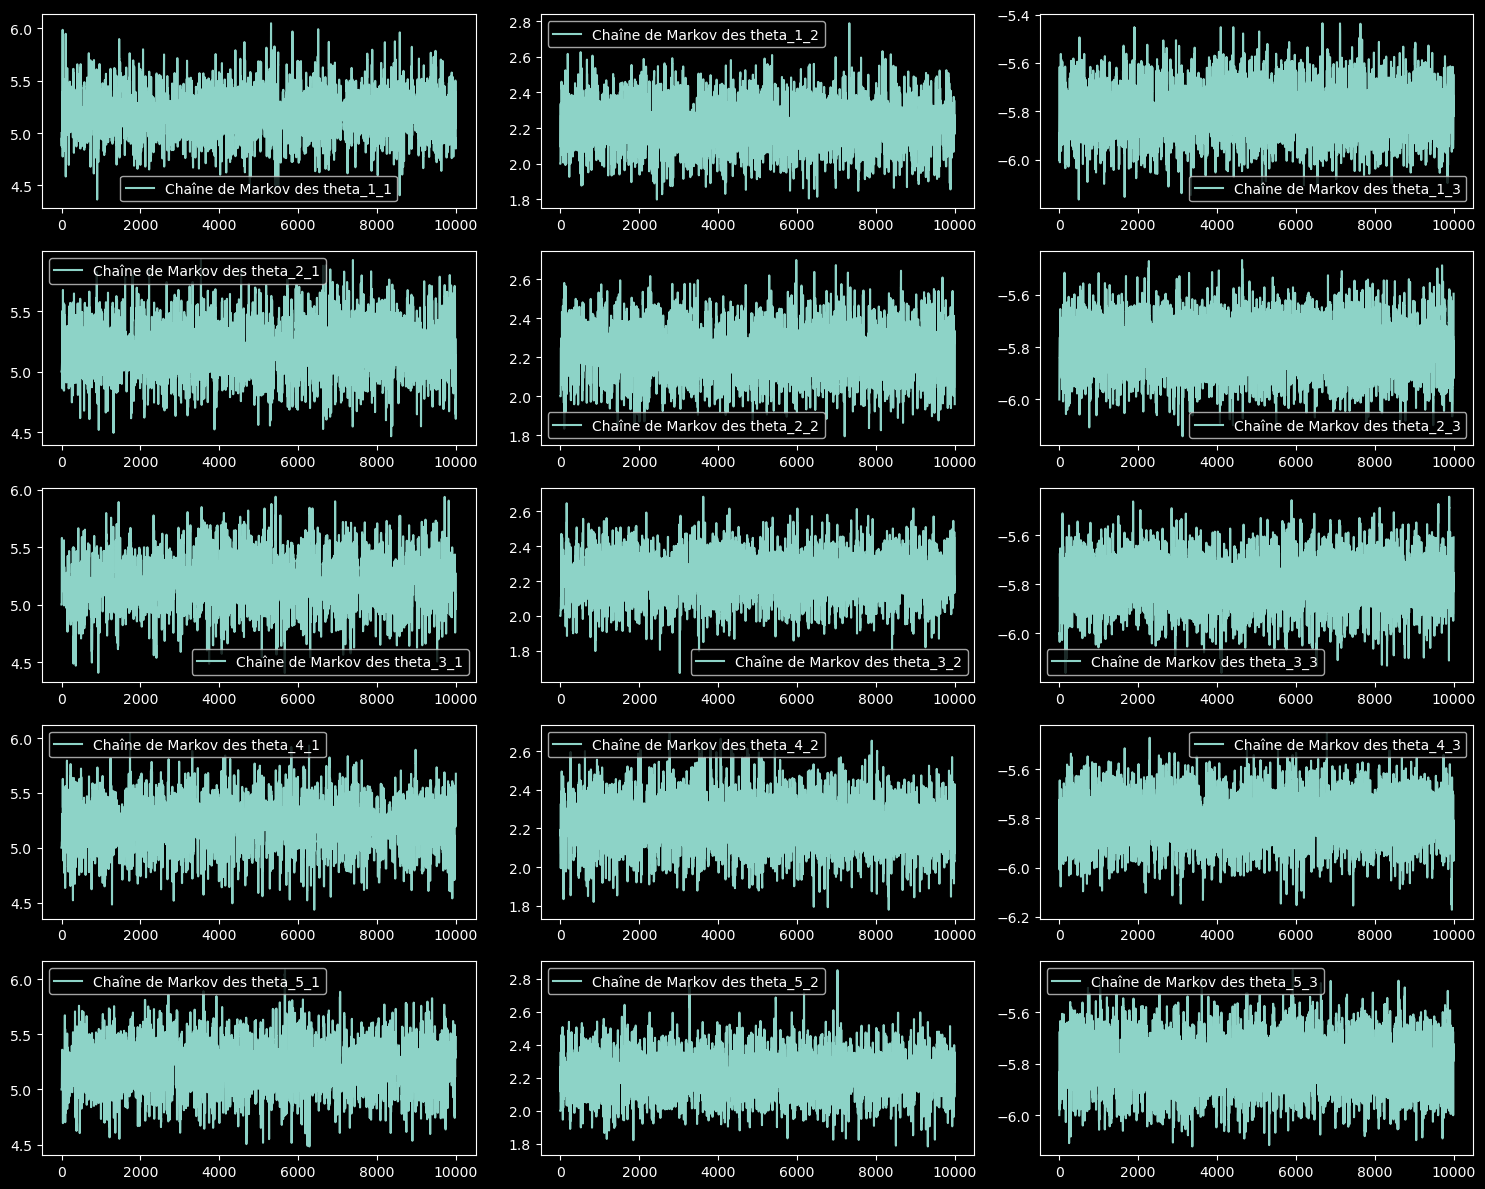

In [231]:
n_k = chain_thetas.shape[1]
plt.figure(figsize=(15, 12))

#Chaines des theta_i_k générés
for i in range(n_k):
    # theta_i_1
    plt.subplot(n_k, 3, 3*i + 1)
    plt.plot(chain_thetas[:,i][:,0], label=f'Chaîne de Markov des theta_{i+1}_1')
    plt.legend()

    # theta_i_2
    plt.subplot(n_k, 3, 3*i + 2)
    plt.plot(chain_thetas[:,i][:,1], label=f'Chaîne de Markov des theta_{i+1}_2')
    plt.legend()

    # theta_i_3
    plt.subplot(n_k, 3, 3*i + 3)
    plt.plot(chain_thetas[:,i][:,2], label=f'Chaîne de Markov des theta_{i+1}_3')
    plt.legend()

plt.tight_layout()
plt.show()

Calculons désormais la moyenne et l'écart-type de chacun de ces paramètres d'après les chaînes de Markov générées.

In [232]:
print("15 chaines des theta_i_k : ")
print("Moyenne : ", np.mean(chain_thetas, axis=0))
print("Écart-type : ", np.std(chain_thetas, axis=0))
print("Taux d'acceptation : ", theta_acc_rates)

15 chaines des theta_i_k : 
Moyenne :  [[ 5.19497074  2.2180463  -5.80208293]
 [ 5.1962266   2.22331874 -5.8016281 ]
 [ 5.19870841  2.22074401 -5.79766174]
 [ 5.20851361  2.227441   -5.80379135]
 [ 5.20518887  2.22204449 -5.80100608]]
Écart-type :  [[0.21256261 0.12684809 0.10083418]
 [0.21935462 0.12568655 0.09778568]
 [0.21663652 0.12670867 0.09977294]
 [0.21767179 0.12702853 0.09918832]
 [0.22601167 0.12847985 0.10096486]]
Taux d'acceptation :  [[0.2455 0.3324 0.5076]
 [0.2513 0.3358 0.4967]
 [0.2558 0.3331 0.4943]
 [0.2497 0.3308 0.4981]
 [0.2575 0.3309 0.4953]]


In [236]:
print("3 chaines des mu_k : ")
print("Moyenne : ", np.mean(chain_mu_k, axis=0))
print("Écart-type : ", np.std(chain_mu_k, axis=0))

3 chaines des mu_k : 
Moyenne :  [ 4.99928058  1.99929933 -5.99934606]
Écart-type :  [0.09857596 0.05738286 0.04502533]


In [240]:
print("3 chaines des tau_k : ")
print("Moyenne : ", np.mean(chain_tau_k, axis=0))
print("Écart-type : ", np.std(chain_tau_k, axis=0))

3 chaines des tau_k : 
Moyenne :  [24.64858502 20.43834649 24.88811951]
Écart-type :  [15.39166381 12.84310323 15.81841393]


In [244]:
print("Chaine de tau_C : ")
print("Moyenne : ", np.mean(chain_tau_C))
print("Écart-type : ", np.std(chain_tau_C))

Chaine de tau_C : 
Moyenne :  0.0006564467297445009
Écart-type :  0.0019993637494852
